In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import pickle
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'
ROOT = os.path.dirname(os.getcwd())

In [2]:
#metrics
player_network_base = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'player_passing_networks_exploration.pkl.gz'))
zone_network_base = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zonal_passing_networks_exploration.pkl.gz'))
lane_intensity = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info_clustered.pkl.gz')) #includes cluster assignment for k=2
lane_cluster_centers = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info_cluster_centers.pkl.gz')).sort_index()
advance_ratio = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'advance_ratio.pkl.gz'))
player_network_advanced = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'player_network_algorithms.pkl.gz'))
defensive_metrics_normalized = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'defensive_metrics_normalized_by_possession.pkl.gz'))
atts_defense = ['possession',
        'yellow_card/possession',
        'total_fouls/possession',
        'dangerous_ball_lost/possession',
        'interception_total/possession',
        'interception_inside_box/possession',
        'sliding_tackle_total/possession',
        'sliding_tackle_inside_box/possession',
        'fraction_slide_tackles_in_box',
        'fraction_interception_in_box',
        'centroid_slidetackles_interceptions_y',
        'centroid_slidetackles_interceptions_x',
        'fouls_committed',
        'yellow_card_per_foul_committed']
defensive_metrics_normalized  = defensive_metrics_normalized [atts_defense]

#performance
match_goals_wins = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'matches_goals_wins.pkl.gz'))
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))

#Combining eveything
df = pd.concat([player_network_base,
                zone_network_base,
                lane_intensity[['cluster']].droplevel(1, axis=1).rename({'cluster': 'passing_lane_cluster'}, axis=1), #Only considering clusters for now
                advance_ratio,
                player_network_advanced,
                defensive_metrics_normalized], axis=1)
df = df.drop(columns = ['fouls_committed', 'yellow_card_per_foul_committed', 'possession', 'total_fouls/possession'])


#df = df.mean(level=1)
#assert 0
#Collapsing from per match to per team level
df = pd.concat([df.mean(level=1), df.var(level=1)],
         keys=['mean', 'var'], axis=1)

# Equal weightage in euclidean space for clustering
df = (df - df.mean())/df.std()
original_data = df.copy()
df

mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  1.936797            1.993363           1.887977         2.009746   
1631 -0.569432           -0.571528          -0.468623        -0.579093   
1625  3.350016            3.406662           3.400785         3.017362   
1651 -0.698530           -0.603258          -0.754753        -0.715641   
1610  1.246287            1.251096           1.332306         1.599085   
...        ...                 ...                ...              ...   
3219 -0.183033           -0.253692           0.019928        -0.167924   
3193 -0.305870           -0.351561          -0.322652        -0.266909   
3315 -0.875034           -0.881524          -0.810637        -0.808535   
3163 -0.525306           -0.588668          -0.661436        -0.457265   
3165 -0.527990           -0.521211          -0.213069        -0.596352   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        1.384351             2.020265      1.706638   
1631       -0.510147            -0.329204     -0.342721   
1625        3.390555             2.167107      2.126620   
1651       -0.826652            -1.797623     -0.300204   
1610        0.856457             0.698689      1.084321   
...              ...                  ...           ...   
3219       -0.085709            -0.182362      0.354051   
3193       -0.505610            -0.182362     -0.202459   
3315       -1.032875            -1.063413     -0.481081   
3163       -0.330596            -0.769730     -0.024488   
3165       -0.742170            -0.622888      0.124748   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   1.979335               0.942322   
1631                  -0.366233              -0.955545   
1625                   2.703903               2.277908   
1651                  -0.293391              -0.582852   
1610                   0.901086               1.193123   
...                         ...                    ...   
3219                  -0.072669              -0.575642   
3193                  -1.094088               0.391742   
3315                  -1.230323              -1.366720   
3163                  -0.780457               0.615376   
3165                  -0.288404              -1.454929   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -1.666993  ...              -0.220527   
1631                    0.619364  ...              -0.551183   
1625                   -2.465925  ...              -1.027938   
1651                    0.665354  ...              -0.749088   
1610                   -1.402504  ...              -0.694944   
...                          ...  ...                    ...   
3219                    0.218342  ...              -0.167027   
3193                    0.086493  ...              -0.555785   
3315                    1.102206  ...               1.852978   
3163                    0.321176  ...               0.594771   
3165                    0.872364  ...               0.768195   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.789182                     -0.778890   
1631                      -0.359889                      0.734001   
1625                      -0.534604                     -1.004716   
1651                       1.014534                      0.495403   
1610                      -0.036124                     -0.339540   
...                             ...                           ...   
3219                       0.716250                     -0.274312   
3193                       0.187168                     -0.327417   
3

### What hapens if we use MI again, but try normalizing it to sum to 1?

In [3]:
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
performance = performance.set_index('area.name', append=True).swaplevel()[['name', 'end_of_season_pts']].sort_index()
performance['rank'] = performance.groupby(level=0).rank(pct=True)
performance['_quartile'] = pd.qcut(performance['rank'], q=4, labels=['q1', 'q2', 'q3', 'q4']) #q4 highest
performance = performance[['_quartile']].droplevel(0)
performance.columns = pd.MultiIndex.from_tuples([('performance', '_quartile')])
df = pd.concat([original_data, performance], axis=1)
df

mean                                                          \
              w mean_passes_players std_passes_players mean_passes_zone   
674   -0.167827           -0.156545           0.188738        -0.032391   
675    1.727497            1.767961           1.252692         1.505684   
676    2.079013            2.030195           1.509412         1.986903   
677   -0.521132           -0.532420          -0.667215        -0.631377   
678   -0.377127           -0.377986          -0.605593        -0.227823   
...         ...                 ...                ...              ...   
3795  -0.770384           -0.834326          -0.866550        -0.956759   
3799  -0.560786           -0.578889          -0.495295        -0.750159   
3804  -0.435862           -0.457505          -0.552697        -0.343559   
10531 -0.430794           -0.450675          -0.420584        -0.375032   
19830 -0.111776           -0.110309           0.231346        -0.027823   

                                                          \
      std_passes_zone passing_lane_cluster advance_ratio   
674         -0.042805             1.579740      1.098193   
675          0.570003             1.432898      1.697164   
676          1.604240             1.726581      1.793790   
677         -0.838640             0.111321     -0.062368   
678         -0.168287             0.551847     -0.537618   
...               ...                  ...           ...   
3795        -1.013445            -1.357097     -0.591535   
3799        -0.583421            -0.769730     -0.486048   
3804        -0.463759            -0.476046     -0.011533   
10531       -0.348876            -1.063413      0.096082   
19830        0.104544             1.139214      0.531511   

                                                         \
      avg_clustering_coefficient algebraic_connectivity   
674                    -0.805537              -0.349543   
675                     1.531757               2.719036   
676                     1.441253               0.828231   
677                    -0.578830               0.227737   
678                     0.656232               1.128884   
...                          ...                    ...   
3795                   -1.160048              -0.550204   
3799                   -0.725153              -1.050818   
3804                   -0.036585              -0.873047   
10531                  -0.860792              -0.798752   
19830                  -0.404672              -0.539892   

                                   ...                            var  \
      avg_shortest_path_all_pairs  ... dangerous_ball_lost/possession   
674                      0.221485  ...                       0.036879   
675                     -1.911460  ...                      -0.192688   
676                     -2.051108  ...                      -0.495791   
677                      0.308466  ...                      -0.039190   
678                     -0.003641  ...                       2.942776   
...                           ...  ...                            ...   
3795                     0.785490  ...                      -0.199119   
3799                     0.352757  ...                      -0.718988   
3804                     0.596591  ...                       0.128352   
10531                    0.574447  ...                       5.881079   
19830                    0.077187  ...                      -0.664660   

                                                                        \
      interception_total/possession interception_inside_box/possession   
674                       -0.338944                          -0.509802   
675                       -1.119162                          -1.005823   
676                       -1.124028                          -0.949731   
677                       -0.560030                          -0.493526   
678                       -0.282790                          -0.169085   
...               

<AxesSubplot:title={'center':'Mutual Information wrt Performance Quartile(Normalized)'}>

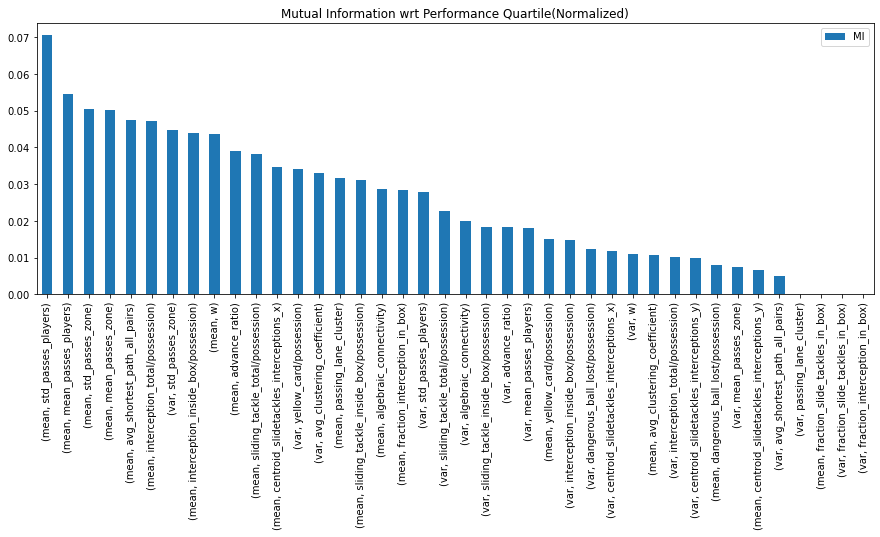

In [9]:
import sklearn.feature_selection
mutual_info = sklearn.feature_selection.mutual_info_classif(df[['mean', 'var']], df[['performance']].to_numpy().ravel())
mutual_info = pd.DataFrame(mutual_info, index=df.columns[:-1], columns=['MI'])
mutual_info = mutual_info / mutual_info.sum()
mutual_info.sort_values(by='MI', ascending=False).plot(kind='bar', figsize=(15, 5), title='Mutual Information wrt Performance Quartile(Normalized)')

## Hierarchical Clustering with normalized MI

In [50]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(15,5))
    dendrogram(linkage_matrix, **kwargs)


scaled_data = original_data.multiply(mutual_info['MI'], axis=1)

In [51]:
scaled_data

mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  0.084746            0.108839           0.133033         0.101086   
1631 -0.024916           -0.031206          -0.033021        -0.029127   
1625  0.146583            0.186006           0.239631         0.151768   
1651 -0.030565           -0.032938          -0.053182        -0.035995   
1610  0.054532            0.068311           0.093879         0.080431   
...        ...                 ...                ...              ...   
3219 -0.008009           -0.013852           0.001404        -0.008446   
3193 -0.013384           -0.019195          -0.022735        -0.013425   
3315 -0.038288           -0.048132          -0.057120        -0.040668   
3163 -0.022985           -0.032142          -0.046607        -0.023000   
3165 -0.023103           -0.028458          -0.015014        -0.029995   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        0.069995             0.064085      0.066645   
1631       -0.025794            -0.010443     -0.013383   
1625        0.171433             0.068743      0.083046   
1651       -0.041797            -0.057023     -0.011723   
1610        0.043304             0.022163      0.042343   
...              ...                  ...           ...   
3219       -0.004334            -0.005785      0.013826   
3193       -0.025565            -0.005785     -0.007906   
3315       -0.052224            -0.033733     -0.018786   
3163       -0.016716            -0.024417     -0.000956   
3165       -0.037525            -0.019759      0.004871   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   0.020963               0.026930   
1631                  -0.003879              -0.027308   
1625                   0.028637               0.065099   
1651                  -0.003107              -0.016657   
1610                   0.009543               0.034098   
...                         ...                    ...   
3219                  -0.000770              -0.016451   
3193                  -0.011587               0.011195   
3315                  -0.013030              -0.039059   
3163                  -0.008266               0.017587   
3165                  -0.003054              -0.041580   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -0.078931  ...              -0.007550   
1631                    0.029326  ...              -0.018872   
1625                   -0.116759  ...              -0.035195   
1651                    0.031504  ...              -0.025647   
1610                   -0.066407  ...              -0.023794   
...                          ...  ...                    ...   
3219                    0.010338  ...              -0.005719   
3193                    0.004095  ...              -0.019029   
3315                    0.052188  ...               0.063443   
3163                    0.015207  ...               0.020364   
3165                    0.041306  ...               0.026302   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.009656                     -0.007993   
1631                      -0.004404                      0.007532   
1625                      -0.006541                     -0.010310   
1651                       0.012414                      0.005084   
1610                      -0.000442                     -0.003484   
...                             ...                           ...   
3219                       0.008764                     -0.002815   
3193                       0.002290                     -0.003360   
3

Text(0.5, 1.0, 'Dendrogram | Bottom Up Hierarchical Clustering')

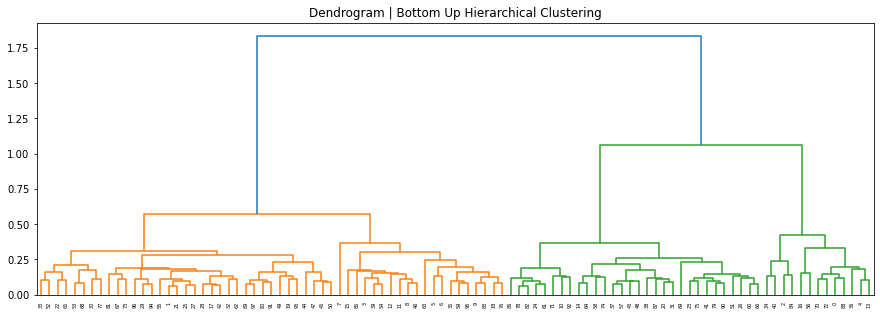

In [52]:
try:
    scaled_data = scaled_data.drop(columns='aggl_cluster')
except:
    pass

model = AgglomerativeClustering(compute_distances = True)
model.fit(scaled_data)
plot_dendrogram(model)
plt.title('Dendrogram | Bottom Up Hierarchical Clustering')

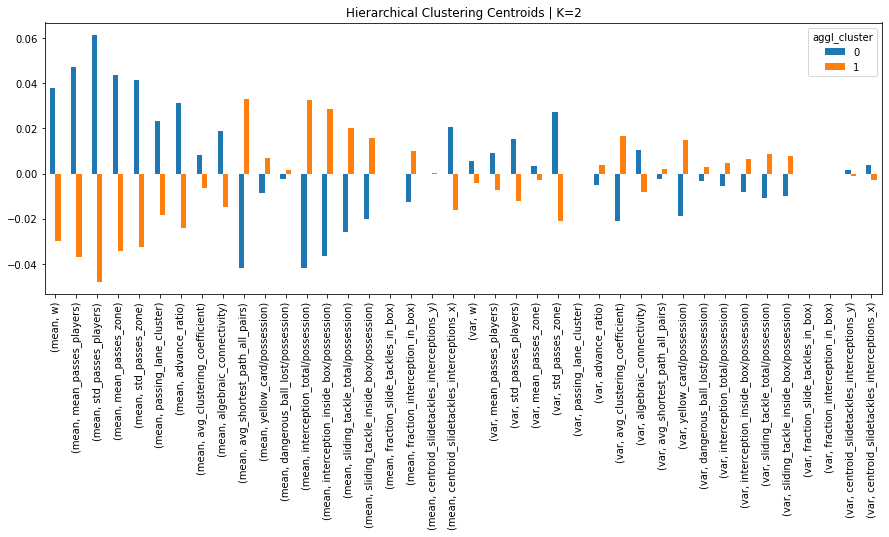

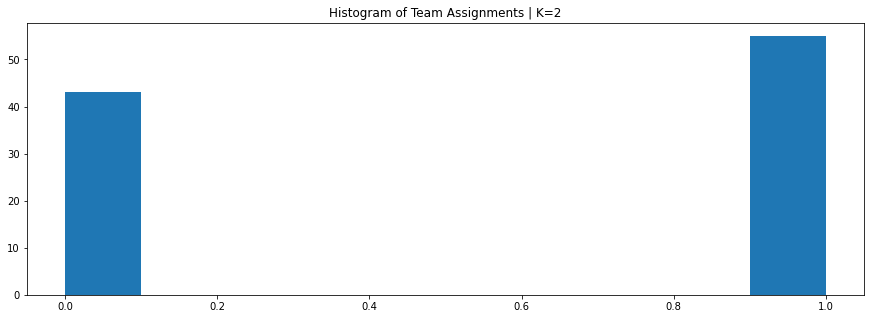

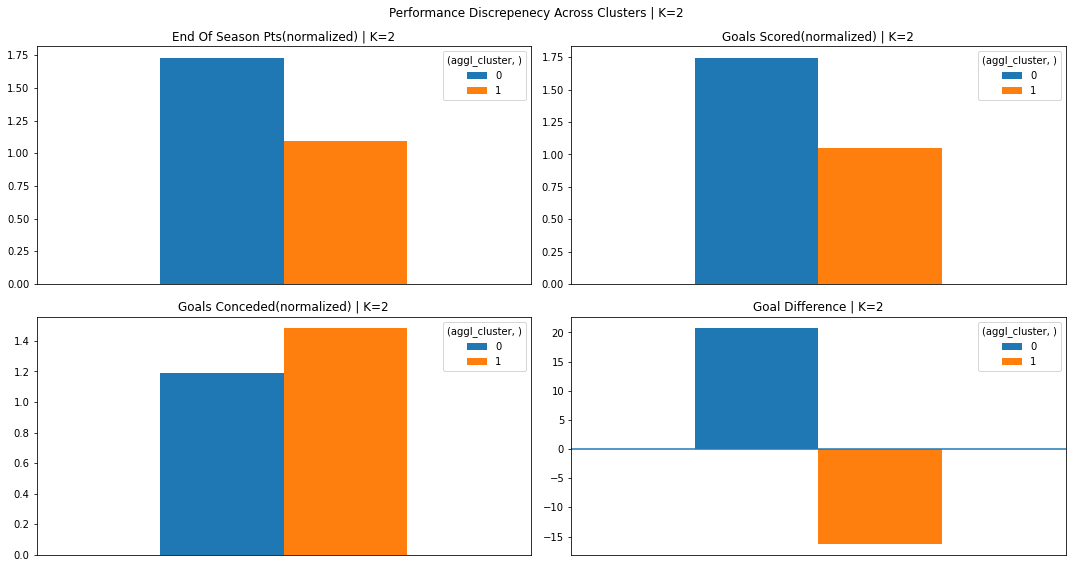

name                 
cluster                  0                1
0              Real Madrid  West Ham United
1              Real Madrid          Levante
2        Borussia Dortmund             Caen
3                 Bordeaux           Angers
4                 Juventus         Guingamp
5                Barcelona           Getafe
6            Real Sociedad           Chievo
7        Tottenham Hotspur             Caen
8                   France         Augsburg
9                Wolfsburg       Strasbourg

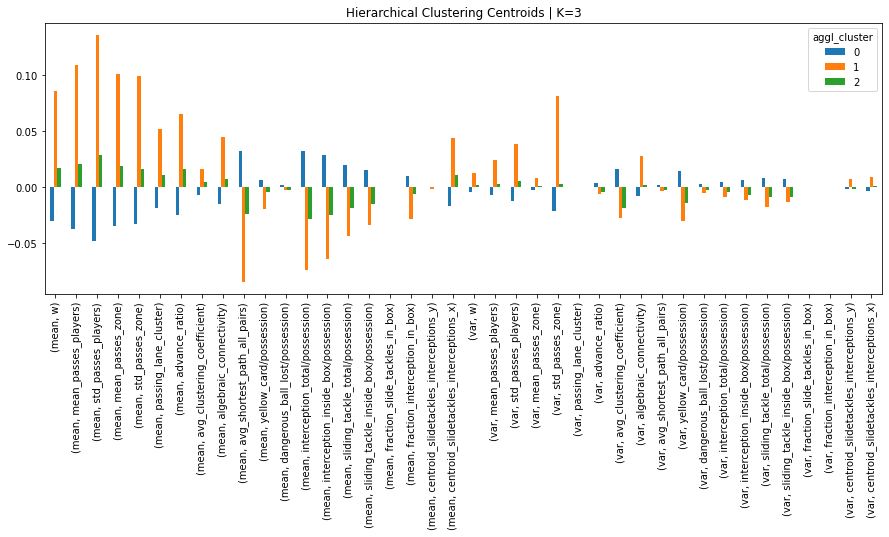

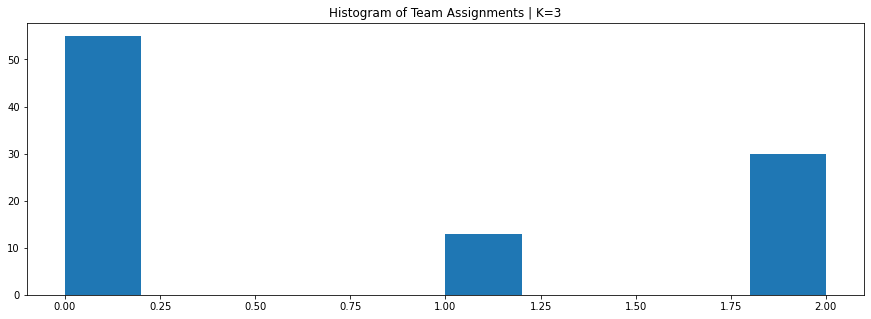

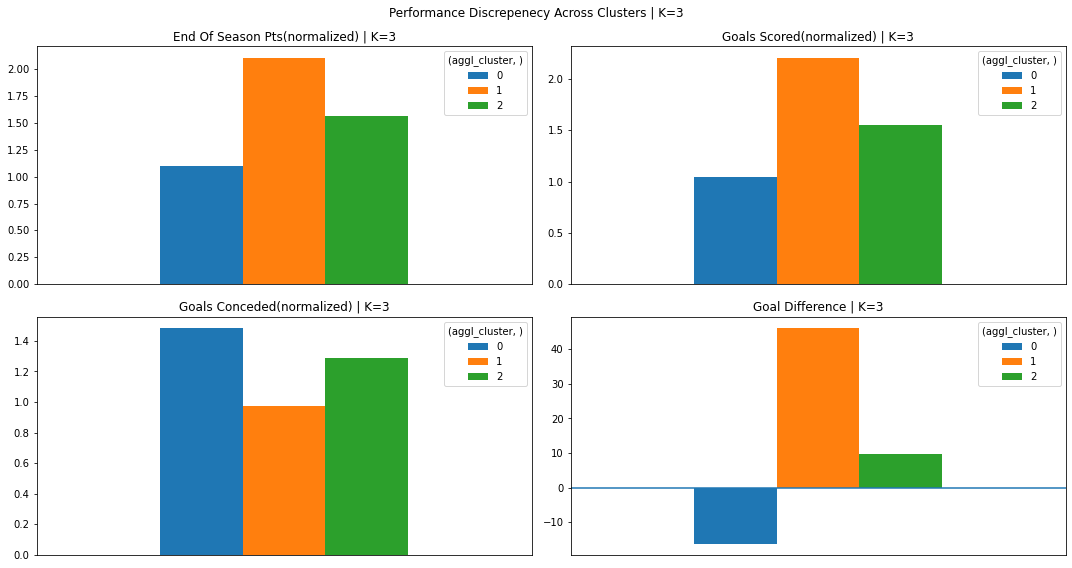

name                                           
cluster                0                    1                     2
0              Amiens SC    Tottenham Hotspur         Celta de Vigo
1                Crotone    Tottenham Hotspur                 Lazio
2                 Nantes  Bayern M\u00fcnchen    Olympique Lyonnais
3                 Getafe            Liverpool                  Roma
4          Werder Bremen          Real Madrid  Atl\u00e9tico Madrid
5            Hannover 96               Napoli            RB Leipzig
6        AFC Bournemouth              Chelsea                 Milan
7             Schalke 04          Real Madrid        Internazionale
8                  Genoa                 Nice                 Lazio
9               Freiburg                  PSG   Borussia M'gladbach

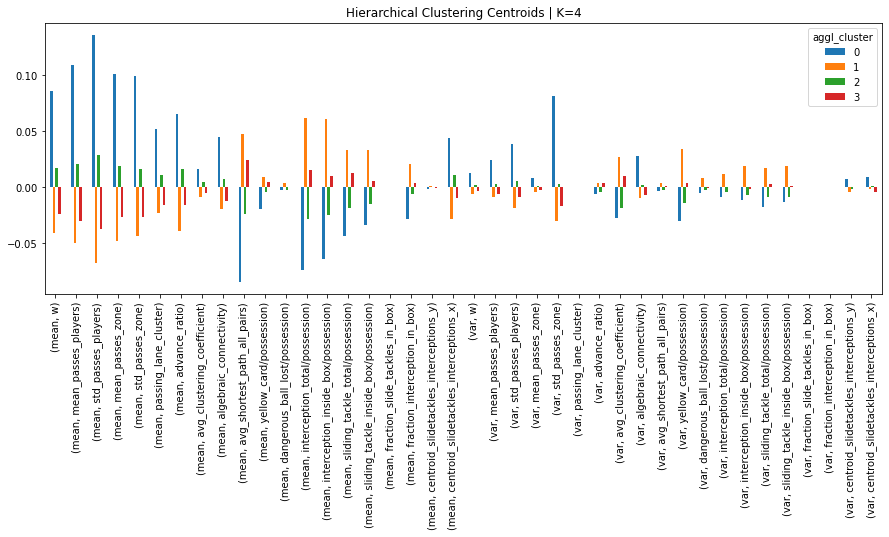

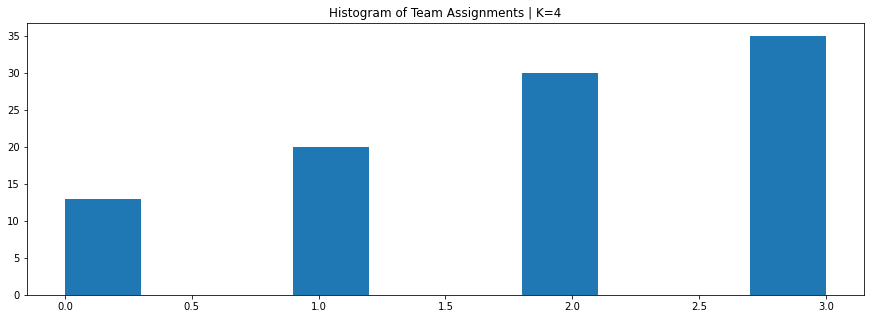

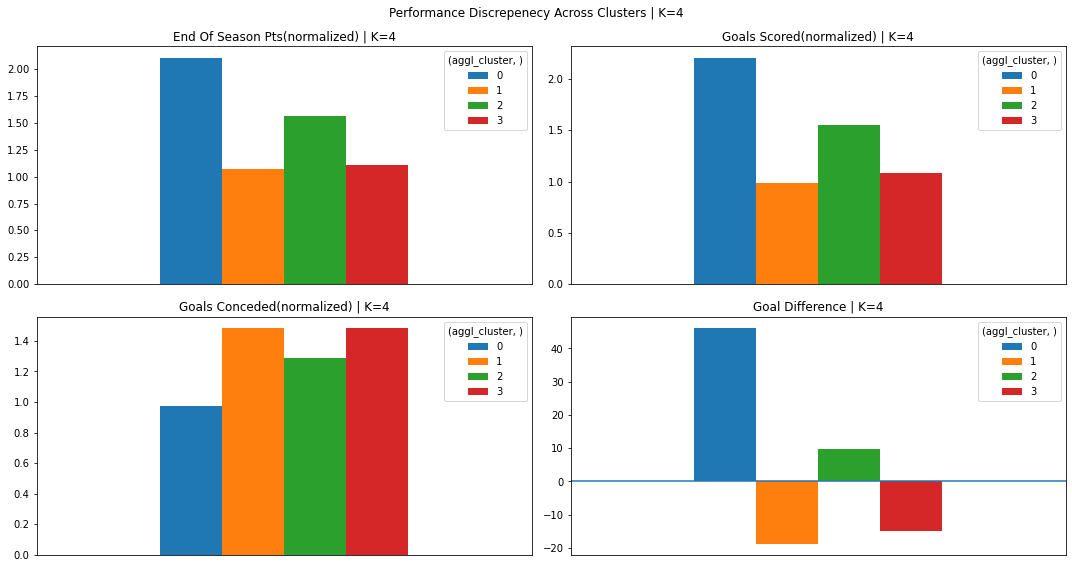

name                                               \
cluster                    0                      1                     2   
0            Manchester City               Sassuolo                 Eibar   
1            Manchester City            Hannover 96             Wolfsburg   
2                    Chelsea                 Troyes              Bordeaux   
3                  Liverpool                Burnley            Las Palmas   
4                        PSG      Huddersfield Town            RB Leipzig   
5                     Napoli   West Bromwich Albion  Atl\u00e9tico Madrid   
6                       Nice                 Troyes            Hoffenheim   
7                    Chelsea             Stoke City         Celta de Vigo   
8        Bayern M\u00fcnchen  Deportivo Alav\u00e9s           Southampton   
9                        PSG  Deportivo Alav\u00e9s            Fiorentina   

                              
cluster                    3  
0                   Toulouse  
1                     Torino  
2                      Genoa  
3                     Girona  
4                     Nantes  
5                     Chievo  
6                    Watford  
7                   Cagliari  
8                     Angers  
9        Eintracht Frankfurt

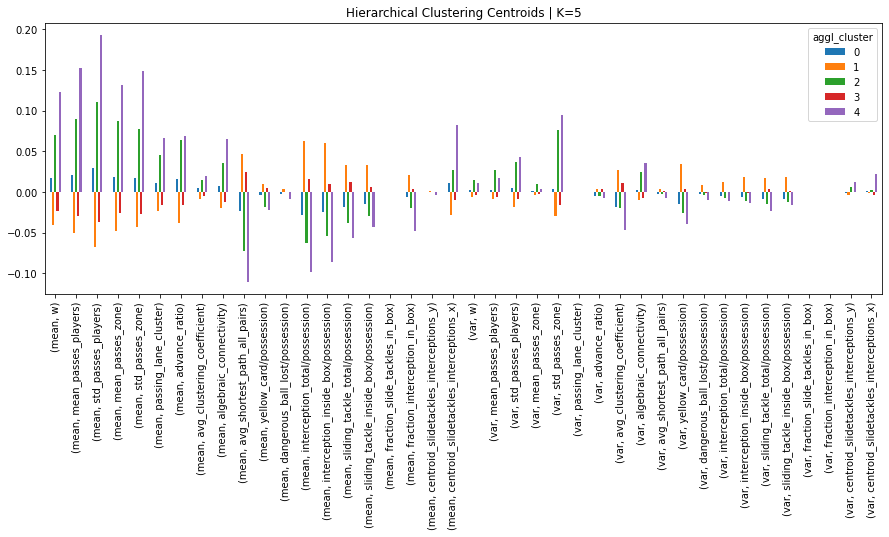

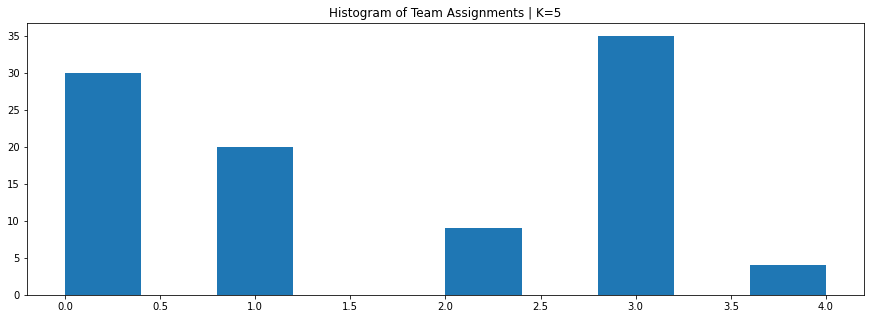

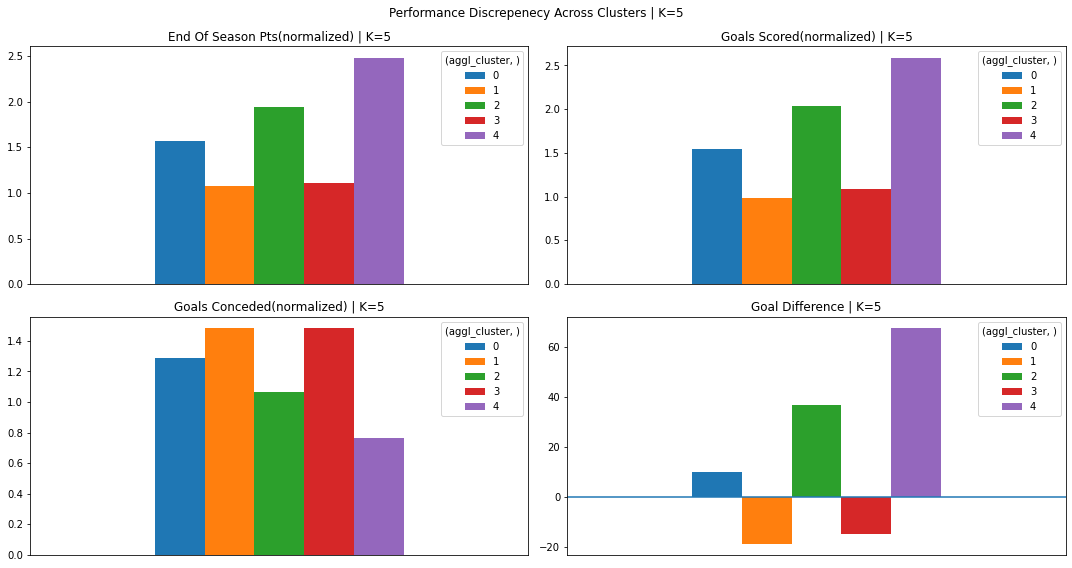

name                                            \
cluster                     0                      1                  2   
0                    Valencia                Burnley            Chelsea   
1        Atl\u00e9tico Madrid        West Ham United            Arsenal   
2                    Atalanta                 Getafe               Nice   
3        Atl\u00e9tico Madrid              Amiens SC  Tottenham Hotspur   
4                      France              Amiens SC            Chelsea   
5               Real Sociedad                Levante  Tottenham Hotspur   
6                  Hoffenheim                Levante           Juventus   
7                    Valencia               Freiburg           Juventus   
8           Manchester United   West Bromwich Albion           Juventus   
9         Olympique Marseille  Deportivo Alav\u00e9s          Liverpool   

                                               
cluster                3                    4  
0               Augsburg               Napoli  
1                 Nantes      Manchester City  
2                 Angers      Manchester City  
3                 Angers               Napoli  
4        AFC Bournemouth               Napoli  
5               Cagliari  Bayern M\u00fcnchen  
6                 Chievo                  PSG  
7          Athletic Club                  PSG  
8            Montpellier               Napoli  
9              Stuttgart      Manchester City

In [72]:
perf =  pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
matches = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'matches_df.pkl.gz'))[['team_home', 'team_away', 'goals_home', 'goals_away']].droplevel(1)
scored = matches.set_index('team_home')[['goals_home']].sum(level=0).rename({'goals_home': 'goals_scored'}, axis=1) + matches.set_index('team_away')[['goals_away']].sum(level=0).rename({'goals_away': 'goals_scored'}, axis=1)
conceded = matches.set_index('team_home')[['goals_away']].sum(level=0).rename({'goals_away': 'goals_conceded'}, axis=1) + matches.set_index('team_away')[['goals_home']].sum(level=0).rename({'goals_home': 'goals_conceded'}, axis=1)
matches = pd.concat([scored, conceded], axis=1)
matches['GD'] = matches['goals_scored'] - matches['goals_conceded']


for k in [2, 3, 4, 5]:

    try:
        scaled_data = scaled_data.drop(columns='aggl_cluster')
    except:
        pass

    model = AgglomerativeClustering(n_clusters=k, compute_distances=True)
    model.fit(scaled_data)
    scaled_data['aggl_cluster'] = model.labels_
    scaled_data.groupby('aggl_cluster').mean().T.plot(kind='bar', figsize=(15,5), title='Hierarchical Clustering Centroids | K={}'.format(k))
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.hist(model.labels_)
    plt.title('Histogram of Team Assignments | K={}'.format(k))
    plt.show()
    
        
    df = pd.concat([scaled_data[['aggl_cluster']], perf[['name', 'area.name','avg_pass_per_game', 'avg_shots_per_game', 'end_of_season_pts']], matches],
             axis=1)
    df = df.set_index(('aggl_cluster', ''))
    df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/34
    df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/38
    sample_assignments = df[['name']]
    #if k == 5:
        #assert 0
    df = df.groupby(df.index).mean()
    
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
    df[['end_of_season_pts']].T.plot(kind='bar', title='End Of Season Pts(normalized) | K={}'.format(k), ax=axes[0, 0])
    df[['goals_scored']].T.plot(kind='bar', title='Goals Scored(normalized) | K={}'.format(k), ax=axes[0, 1])
    df[['goals_conceded']].T.plot(kind='bar', title='Goals Conceded(normalized) | K={}'.format(k), ax=axes[1, 0])
    df[['GD']].T.plot(kind='bar', title='Goal Difference | K={}'.format(k), ax=axes[1, 1])
    axes[1,1].axhline(0)
    
    for axx in axes:
        for ax in axx:
            ax.set_xticks([])
    
    plt.suptitle('Performance Discrepenecy Across Clusters | K={}'.format(k))
    plt.tight_layout()
    plt.show()
    
    sample_assignments = sample_assignments.groupby(sample_assignments.index).apply(pd.DataFrame.sample, n=10, replace=True).droplevel(1)
    sample_assignments = sample_assignments.reset_index().rename({('aggl_cluster', '') : 'cluster'}, axis=1)
    sample_assignments.index = [i%10 for i in sample_assignments.index]
    sample_assignments = sample_assignments.pivot(columns='cluster')
    display(sample_assignments)
    
    print('\n'*10)
    

In [71]:
df[df.index==4]

,name,area.name,avg_pass_per_game,avg_shots_per_game,end_of_season_pts,goals_scored,goals_conceded,GD
"(aggl_cluster, )",,,,,,,,
4,Manchester City,England,724.289474,15.868421,2.631579,2.789474,0.710526,79
4,Bayern M\u00fcnchen,Germany,647.500000,15.735294,2.470588,2.705882,0.823529,64
4,Napoli,Italy,707.210526,15.921053,2.394737,2.026316,0.763158,48
4,PSG,France,629.157895,14.684211,2.447368,2.842105,0.763158,79


df

In [73]:
df['end_of_season_pts'].T

(aggl_cluster, )
0    1.569040
1    1.076084
2    1.942896
3    1.107607
4    2.486068
Name: end_of_season_pts, dtype: float64

## Do K-Means and GMM converge?

Ie: How closely do the argmax of GMM and KMeans correlate?

Initialization 0
  Iteration 10
Initialization converged: True


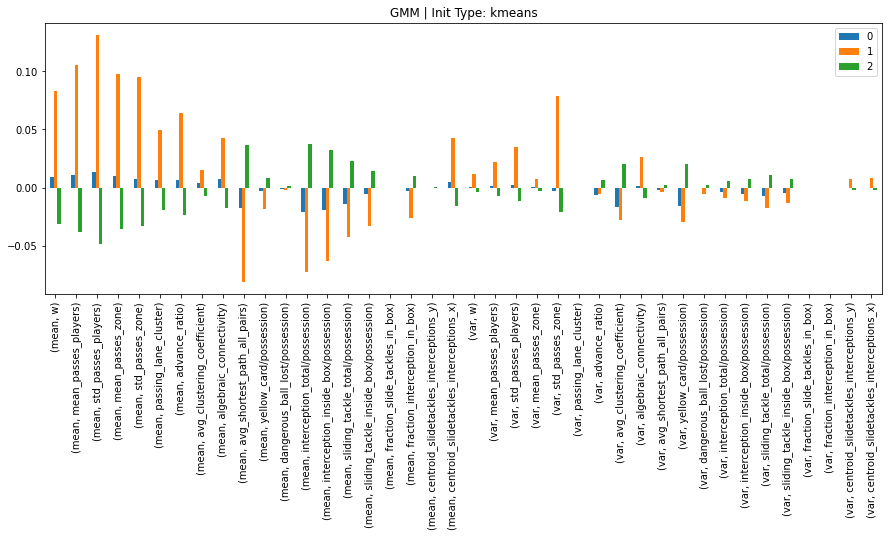

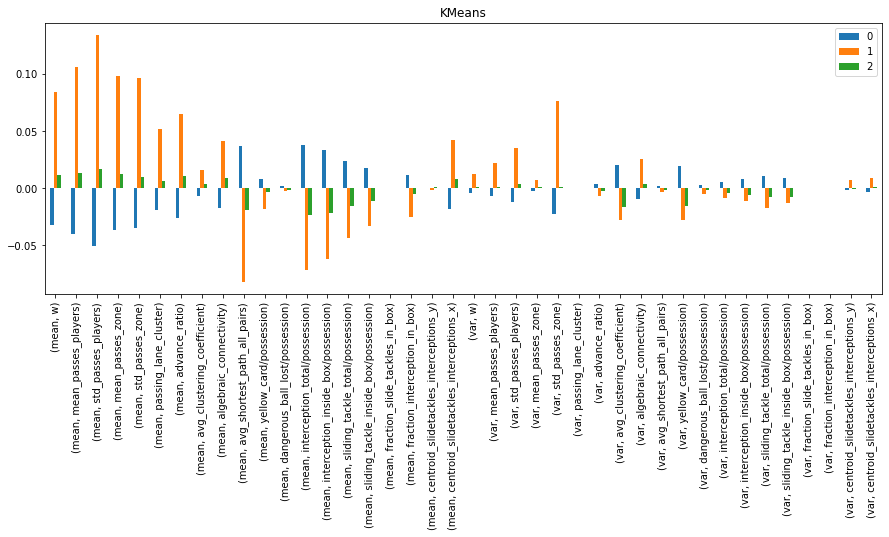

Matching 87
Total 98


,0,1,2
1609,3.330444e-10,1.000000e+00,2.947378e-18
1631,2.881615e-04,9.050412e-22,9.997118e-01
1625,4.647205e-19,1.000000e+00,2.317629e-26
1651,1.924133e-05,4.948438e-16,9.999808e-01
1610,2.878834e-11,1.000000e+00,1.086833e-19
...,...,...,...
3219,9.877458e-01,9.310349e-18,1.225420e-02
3193,9.838665e-01,5.442269e-13,1.613347e-02
3315,1.219765e-07,5.771820e-20,9.999999e-01
3163,5.367141e-07,4.801193e-21,9.999995e-01













Initialization 0
Initialization converged: True


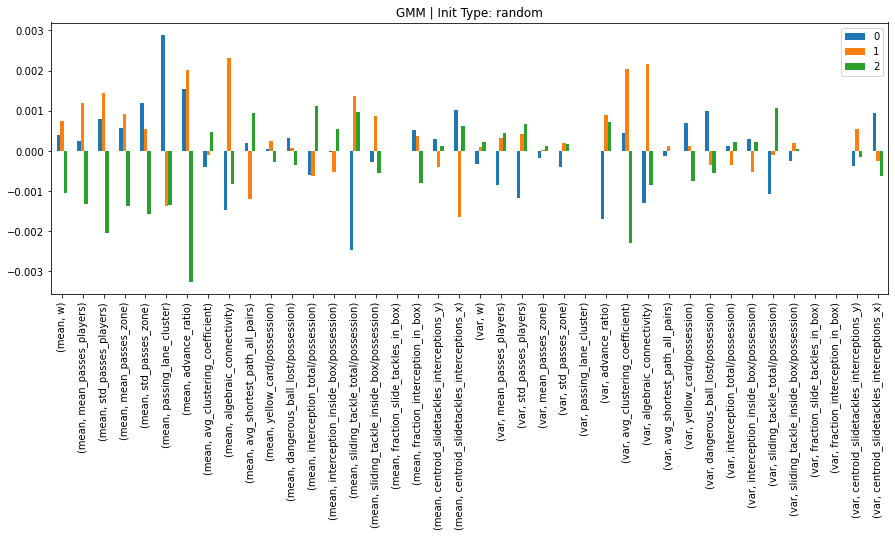

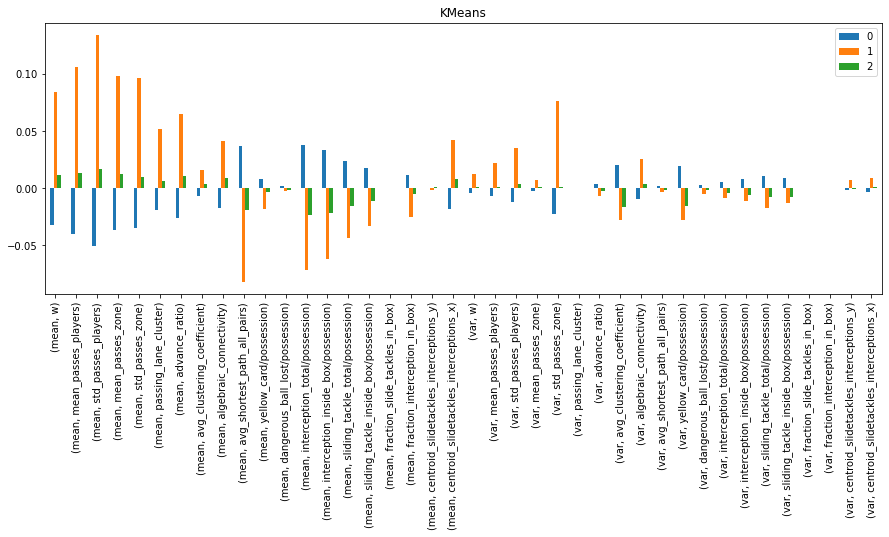

Matching 35
Total 98


,0,1,2
1609,0.236074,0.319660,0.444266
1631,0.343851,0.249140,0.407009
1625,0.206390,0.441616,0.351994
1651,0.157286,0.577713,0.265000
1610,0.315012,0.436291,0.248698
...,...,...,...
3219,0.363155,0.361197,0.275648
3193,0.346494,0.312773,0.340733
3315,0.357695,0.326233,0.316073
3163,0.244137,0.422063,0.333800


In [74]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans


for init_type in ['kmeans', 'random']:


    try:
        scaled_data = scaled_data.drop(columns='aggl_cluster')
    except:
        pass

    gmm = GMM(n_components=3, verbose=1, init_params=init_type, covariance_type='tied', random_state=0)
    gmm.fit(scaled_data)

    means = pd.DataFrame(gmm.means_, columns=scaled_data.columns)
    means.T.plot(kind='bar', figsize=(15, 5), title='GMM | Init Type: {}'.format(init_type))
    plt.show()


    kmeans_classifier = KMeans(n_clusters=3, random_state=0).fit(scaled_data)
    cluster_centers = pd.DataFrame(kmeans_classifier.cluster_centers_).iloc[:, :].T
    cluster_centers.index = scaled_data.columns
    cluster_centers.plot(kind='bar', figsize=(15, 5))
    plt.title('KMeans')
    plt.show()

    combined = pd.concat([pd.Series(gmm.predict(scaled_data)), pd.Series(kmeans_classifier.predict(scaled_data))], axis=1, keys=['GMM', 'KMeans'])
    idx_2 = combined['GMM'][combined['GMM']==2].index
    idx_0 = combined['GMM'][combined['GMM']==0].index
    
    #if init_type == 'random': assert 0

    combined.loc[idx_0, 'GMM'] = 2
    combined.loc[idx_2, 'GMM'] = 0

    print('Matching', (combined['GMM'] == combined['KMeans']).sum())
    print('Total', combined.shape[0])
    
    display(pd.DataFrame(gmm.predict_proba(scaled_data), index=scaled_data.index))
    
    print('\n' * 10)
